In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc

In [2]:
# خواندن داده‌ها از فایل CSV
df = pd.read_csv('BOM.csv', na_values='NA')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
# حذف ستون Date زیرا برای پیش‌بینی لازم نیست
df = df.drop('Date', axis=1)

In [4]:
# جدا کردن ویژگی‌ها و هدف
X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']

In [5]:
# کدگذاری هدف (RainTomorrow: No -> 0, Yes -> 1)
le = LabelEncoder()
y = le.fit_transform(y.astype(str))

In [6]:
# شناسایی ستون‌های کتگوری و عددی
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

In [7]:
categorical_cols

Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday'], dtype='object')

In [8]:
numerical_cols

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm'],
      dtype='object')

In [9]:
# مدیریت مقادیر گم‌شده برای عددی (با میانگین)
num_imputer = SimpleImputer(strategy='mean')
X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])

In [21]:
# مدیریت مقادیر گم‌شده برای کتگوری (با most_frequent)
cat_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])

In [10]:
# کدگذاری ستون‌های کتگوری با OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = pd.DataFrame(ohe.fit_transform(X[categorical_cols]), columns=ohe.get_feature_names_out(categorical_cols))
X = pd.concat([X[numerical_cols].reset_index(drop=True), X_encoded.reset_index(drop=True)], axis=1)

In [12]:
X.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes,RainToday_nan
0,13.4,22.9,0.6,5.629544,7.700305,44.0,20.0,24.0,71.0,22.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,7.4,25.1,0.0,5.629544,7.700305,44.0,4.0,22.0,44.0,25.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,12.9,25.7,0.0,5.629544,7.700305,46.0,19.0,26.0,38.0,30.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,9.2,28.0,0.0,5.629544,7.700305,24.0,11.0,9.0,45.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,17.5,32.3,1.0,5.629544,7.700305,41.0,7.0,20.0,82.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
# حذف ردیف‌هایی که هدف NaN دارند (اگر وجود داشته باشد)
valid_idx = ~np.isnan(y)
X = X[valid_idx]
y = y[valid_idx]

In [14]:
# تقسیم داده‌ها به train و test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
print(f"X_train: {X_train.shape[0]} samples")
print(f"X_test:  {X_test.shape[0]} samples")

X_train: 8564 samples
X_test:  2141 samples


In [16]:
# پیاده‌سازی مدل KNN (با k=5 به عنوان پیش‌فرض)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [17]:
# پیش‌بینی
y_pred = knn.predict(X_test)

In [19]:
# ارزیابی مدل
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Accuracy: 0.8505371321812237
F1 Score: 0.8379555105078923


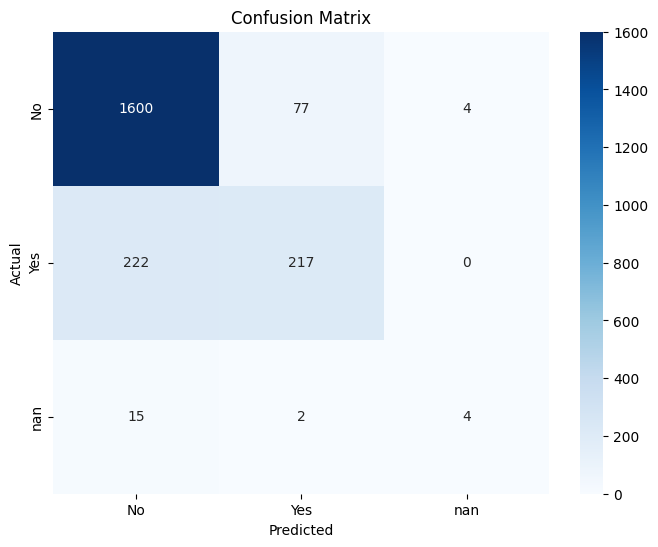

In [25]:
# نمودار 1: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

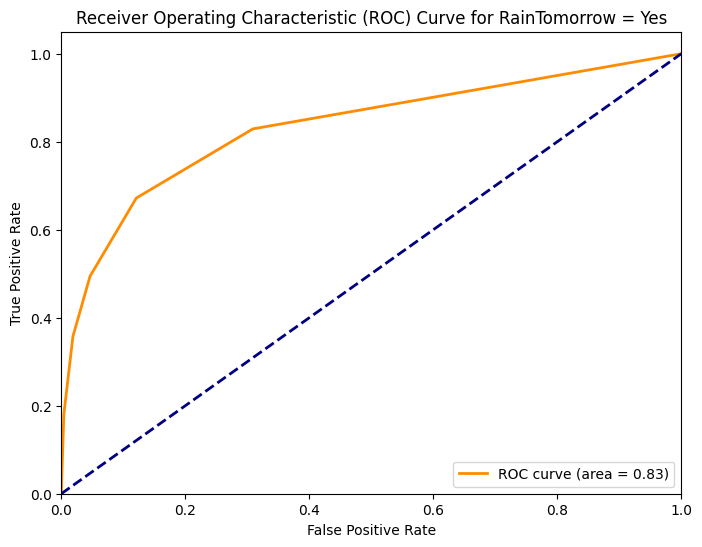

In [30]:
# نمودار 2: ROC Curve
y_prob = knn.predict_proba(X_test)
# Assuming 'Yes' (rain tomorrow) is encoded as 1. Binarize y_test for ROC curve.
y_test_binarized = (y_test == 1).astype(int)
fpr, tpr, _ = roc_curve(y_test_binarized, y_prob[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for RainTomorrow = Yes')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()

/tmp/ipython-input-772907196.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='Set2')


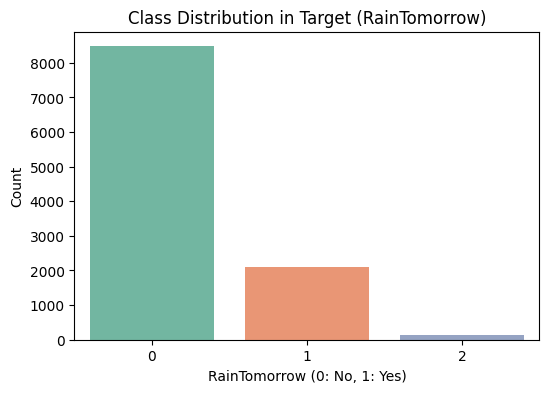

In [31]:
# نمودار 3: توزیع کلاس‌ها (برای نشان دادن imbalance)
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette='Set2')
plt.title('Class Distribution in Target (RainTomorrow)')
plt.xlabel('RainTomorrow (0: No, 1: Yes)')
plt.ylabel('Count')
plt.savefig('class_distribution.png')
plt.show()